In [317]:
from typing import Annotated
import operator,json
from typing import TypedDict, Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph,END,START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults

In [318]:
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")

In [319]:
llm.invoke("hi").content

'Hi! 👋  How can I help you today? 😊\n'

In [320]:
@tool
def multiply(first_number:int, second_number:int)->int:
    """multiply two integer number"""
    return first_number * second_number

In [321]:
@tool
def search(query:str):
    """perform the web search on the user query"""
    tavily=TavilySearchResults()
    result=tavily.invoke(query)
    return result

# @tool
# def search(query:str):
#     """Perform the web search on the query"""
#     return TavilySearchResults().invoke(query)[0]

In [322]:
search.invoke("hello world") # this will return a list of search results

[{'title': '"Hello, World!" program - Wikipedia',
  'url': 'https://en.wikipedia.org/wiki/%22Hello,_World!%22_program',
  'content': 'A "Hello, World!" program is usually a simple computer program that emits displays to the screen (often the console) a message similar to "Hello, World!". A small piece of code in most general-purpose programming languages, this program is used to illustrate a language\'s basic syntax. Such program is often the first written by a student of a new programming language,[1] but such a program can also be used as a sanity check to ensure that the computer software intended to compile or run source [...] External links\n[edit]\n\nWikimedia Commons has media related to Hello World.\n\nThe Wikibook Computer Programming has a page on the topic of: Hello world [...] The program above prints hello, world! on the terminal, including a newline character. The phrase is divided into multiple variables because in B a character constant is limited to four ASCII characte

In [323]:
tools=[search,multiply]

In [324]:
model_with_tools=llm.bind_tools(tools)

In [325]:
tools_mapping={tool.name : tool for tool in tools}

In [326]:
tools_mapping

{'search': StructuredTool(name='search', description='perform the web search on the user query', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x70fb1f417eb0>),
 'multiply': StructuredTool(name='multiply', description='multiply two integer number', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x70fb1f417130>)}

In [327]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]


# class AgentState(TypedDict):
#     """Agent state."""
#     # memory: MemorySaver
#     # graph: StateGraph
#     # current_node: str
#     # current_tool: str
#     # current_message: BaseMessage
#     messages:Annotated[Sequence[BaseMessage], operator.add]

In [328]:
def invoke_model(state:AgentState):
    messages = state['messages']
    question = messages[-1]   ## Fetching the user question
    return {"messages":[model_with_tools.invoke(question)]}

In [329]:
# def invoke_tool(state:AgentState):
#     tool_details= state["messages"][-1].additional_kwargs.get("tool_calls",[])
#     if tool_details is None:
#         raise ValueError("No tool calls found in the message")
    
#     print(f"Selected tool:{tool_details[0]['function']['name']}")

#     if tool_details[0]["function"]["name"] =="search":
#         response=input(prompt=f"[y/n] continue with expensive web search")
#         if response.lower()=="n":
#             return Exception("web Seach Discarded")


#     response=tools_mapping[tool_details[0]["function"]["name"]].invoke(json.loads(tool_details.get("function")))
#     return {"messages":[response]}
#     # messages=state["messages"]
#     # question=messages[-1]
#     # tool_name=question.tool
#     # tool=tools_condition[tool_name]
#     # inputs=tool.get_inputs(question)
#     # result=tool.invoke(**inputs)
#     # return {"messages":[result]}
#     # pass
def invoke_tool(state:AgentState):
    tool_details= state['messages'][-1].additional_kwargs.get("tool_calls", [])[0]
    
    if tool_details is None:
        raise Exception("no tool call found")
    
    print(f'Selected tool: {tool_details.get("function").get("name")}')
    
    if tool_details.get("function").get("name")=="search":
        response = input(prompt=f"[y/n] continue with expensive web search?")
        if response == "n":
            raise Exception("web search discard")
        
    response = tools_mapping[tool_details['function']['name']].invoke(json.loads(tool_details.get("function").get("arguments")))
    return {"messages" : [response]}


In [330]:
def router(state):
    tool_calls = state['messages'][-1].additional_kwargs.get("tool_calls", [])
    if len(tool_calls):
        return "tool"
    else:
        return "end"

In [331]:
graph= StateGraph(AgentState)

graph.add_node("ai_assistant", invoke_model)
graph.add_node("tool", invoke_tool)

In [332]:
graph.add_conditional_edges("ai_assistant", 
            router,
            {
                "tool": "tool",
                "end": END
            }                
            )
graph.add_edge("tool",END)

# graph.add_edge("tool","ai_assistant")
graph.set_entry_point("ai_assistant")


In [333]:
app=graph.compile()

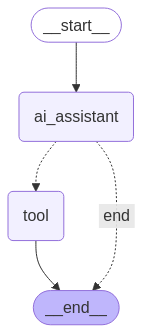

In [334]:
app

In [335]:
for s in app.stream({"messages": ["who is upcoming president of USA?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_djsx', 'function': {'arguments': '{"query":"upcoming president of USA"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 83, 'prompt_tokens': 1075, 'total_tokens': 1158, 'completion_time': 0.150909091, 'prompt_time': 0.046377056, 'queue_time': 0.232487859, 'total_time': 0.197286147}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b99138aa-b35d-4d64-bed0-43562006cc9f-0', tool_calls=[{'name': 'search', 'args': {'query': 'upcoming president of USA'}, 'id': 'call_djsx', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1075, 'output_tokens': 83, 'total_tokens': 1158})]}
----
Selected tool: search
{'messages': [[{'title': '2024 United States presidential election - Wikipedia', 'url': 'https://en.wikipedia.org/wiki/2024_United_States_presidential_election', 'content': "2024 Un

In [339]:
res= app.invoke({"messages":["who is the president of the USA?"]})

Selected tool: search


In [340]:
res

{'messages': ['who is the president of the USA?',
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_arp9', 'function': {'arguments': '{"query":"Who is the president of the USA?"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 1076, 'total_tokens': 1162, 'completion_time': 0.156363636, 'prompt_time': 0.046433519, 'queue_time': 0.23141349999999997, 'total_time': 0.202797155}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-80ada77a-8ce5-46d9-b4d2-0a18abb186cb-0', tool_calls=[{'name': 'search', 'args': {'query': 'Who is the president of the USA?'}, 'id': 'call_arp9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1076, 'output_tokens': 86, 'total_tokens': 1162}),
  [{'title': 'List of presidents of the United States - Wikipedia',
    'url': 'https://en.wikipedia.org/wiki/List_of_presidents_of_the_United_States

In [341]:

for s in app.stream({"messages":["What is multiplication of 34 and 2?"]}):
    print(list(s.values())[0])
    print("-----------------")
    # if s.get("messages")[-1].type=="tool":
    #     print("tool invoked")
    #     break


{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_sba0', 'function': {'arguments': '{"first_number":34,"second_number":2}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 90, 'prompt_tokens': 1079, 'total_tokens': 1169, 'completion_time': 0.163636364, 'prompt_time': 0.061294753, 'queue_time': 0.232093476, 'total_time': 0.224931117}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ee3c7efd-000f-4ac2-be97-4847d1ce014a-0', tool_calls=[{'name': 'multiply', 'args': {'first_number': 34, 'second_number': 2}, 'id': 'call_sba0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1079, 'output_tokens': 90, 'total_tokens': 1169})]}
-----------------
Selected tool: multiply
{'messages': [68]}
-----------------
